#  1 - Overview: build NN to recognize cats

1. Build the general **architecture** of a learning algorithm, including:
- Initializing parameters
- Calculating the cost function and its gradient
- Using an optimization algorithm (gradient descent)
   
2. Gather all three functions above into a main model function, in the right order.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
import imageio

%matplotlib inline

# 2 - Load dataset

- y = 0 or 1
- every image of shape is (num_px, num_px, 3) (height, width, RGB)

## 2.1 def load_dataset()

In [14]:
# Loading the data
def load_dataset():  
    train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
    # 209 samples, 64 * 64 pixels
    train_X = np.array(train_dataset["train_set_x"][:]) # (209, 64, 64, 3) 
    train_y = np.array(train_dataset["train_set_y"][:]) # (209,)
  
    test_dataset = h5py.File('data/test_catvnoncat.h5', "r")  
    # 50 samples
    test_X = np.array(test_dataset["test_set_x"][:]) # (50, 64, 64, 3)
    test_y = np.array(test_dataset["test_set_y"][:]) # (50,)
  
    # label
    classes = np.array(test_dataset["list_classes"][:]) # [b'non-cat' b'cat'] 
    
    # y = [...] => y = [[...]]
    train_y = np.array([train_y]) # train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = np.array([test_y]) # test_y = test_y.reshape((1, test_y.shape[0])) 
    
    return train_X, train_y, test_X, test_y, classes

In [15]:
train_X, train_y, test_X, test_y, classes = load_dataset()

## 2.2 - Show Image

- plt.imshow()

y =  1


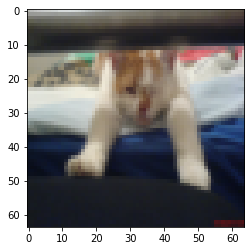

In [16]:
index = 29
plt.imshow(train_X[index]) # first image
print('y = ', train_y[0][index]) # is cat = 1

# 3 - Standardize dataset

## 3.1 - Reshape datasets

In [17]:
"""
flatten dataset
  train_X (209, 64, 64, 3)
  一个样本图片: 64 * 64 * 3, 需要拍平 (64 * 64 * 3) * 1 vector
"""

# flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b*c*d, a) is to use

# (12288, 209) 一行 一个样本数据 209个样本数据
train_set_flatten = train_X.reshape(train_X.shape[0], -1).T 
test_set_flatten = test_X.reshape(test_X.shape[0], -1).T


## 3.2 - "Standardize" the data

### `Mean normalization 均值归一化处理`

In [18]:
"""
RGB: 取值范围为 0~255
X数据需要 / 255
"""
# (12288, 209)
train_set_flatten = train_set_flatten / 255
# (12288, 50)
test_set_flatten = test_set_flatten / 255
print(test_set_flatten.shape)

(12288, 50)


# 4 - Neural Network

$z = w^T * x + b$

$a = sigma(z) / ReLU(z) / tanh(z)$

$L(a, y) = -ylog(a) - (1-y)log(1-a)$

$J = 1/m * \sum(L(a, y))$

## 4.1 - Helper functions

- sigmoid function
- tanh function
- ReLU function

In [54]:
# Sigmoid
# RuntimeWarning: overflow encountered in exp 
def sigmoid (z):
    return 1 / ( 1 + np.exp(-z))

# Sigmoid Derivatives
def sigmoid_derivatives (a):
    return a * (1 - a)

## 4.2 - Initializing parameters

train_set_flatten => (12288, 209)

features = 12288
no. of samples = 209

#### `一列为一组数据`
#### `bias 初始化值选取一定要是0, 选择随机数的话, 和预测差距会很大`


In [55]:
def initialize_parameters (input_n, output_n):
    # input_n: 输入个数, output_n 输出个数
    # 一列为一组数据
    W = np.zeros(shape=(input_n, 1))
    # W = np.random.randn(input_n, output_n)
    
    # 如果将b设置为随机数的话, 最后的值, 变化非常的大, 效果非常的不好。
    # b = np.zeros((output_n, 1))
    b = 0
    
    return W, b

## 4.3 - Forward Propagation

$z = w^T * x + b$

$a = sigma(z) / ReLU(z) / tanh(z)$


In [56]:
def forward_propagation (W, b, X):
    # W, B: 一列为一组数据
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)
    return A

# W = np.random.randn(3, 2)  # input_n = 3(Layer1), output_n = 2 (Layer2)
# X = np.random.randn(3, 10) # 10 samples, 3 feautures
# b = np.random.randn(2, 1)  # output_n = 2
# Z: 2 * 10 (Layer2: 2 nodes, 10 samples)

# forward_propagation(W, b, X)

##  4.4 - Cost Function

$L(a, y) = -ylog(a) - (1-y)log(1-a)$

损失函数的总数: $J = 1/m * \sum(L(a, y))$

`不要忘记 1/m * sum(L) 是均值`

`数据如果没有归一化处理, 则算出来的J, 有可能是负数哦😯!!!`

In [57]:
def loss_function (y, a):
    # one sample
    return -y * np.log(a) - (1 - y) * np.log(1 - a)

def Loss_Fn (Y, A):
    # all samples (1, 209)
    m = Y.shape[1]
    
    # log(0)会遇到报错情况
    epsilon = 1e-5
    J = (1 / m) * np.sum(-Y * np.log(A + epsilon) - (1 - Y) * np.log(1 - A + epsilon))
    return J

## 4.5 - Backward Propagation

$dl / da = - y / a - (1 - y) / (1 - a)$

$da / dz = a(1 - a)$

$dl / dz = a - y$ 
=> $dL / dZ = (1/m) * np.sum(A - Y)$

$dL / dB = dL / dZ = A - Y$ 
$dL / dW = W.T * (A - Y)$ 

In [58]:
def backward_propagation (Y, A, X):
    # eg: A: 1 * m, Y: 1 * m X: 3 * m
    m = A.shape[1]
    dL_dZ = A - Y

    dL_dW = (1 / m) * np.dot(X, (A - Y).T)
    dL_dB = (1 / m) * np.sum(A - Y)
    
    return dL_dW, dL_dB

# 4.6 - train

steps:
1. Initializing parameters
2. Forward Propagation
3. Backward Propagation
4. iterations: 2,3,4

hyperparameters:
1. learning rate
2. activation function
3. numbers in each layer: $n^{[l]}$
4. Layers: L

In [59]:
def train (X, Y, alpha, iterations):
    # test data
    """
    input_nums = 3
    output_nums = 1
    X = np.ones((3, 10))
    Y = np.ones((1, 10))
    """
    
#     X = train_set_flatten # (12288, 209)
#     Y = train_y # (1, 209)

    input_nums = X.shape[0]
    output_nums = 1
    
    # hyperparameters
#     alpha = 0.005
#     iterations = 2000

    # 1.Initializing parameters
    W, b = initialize_parameters(input_nums, output_nums)
    J_arr = []

    # 4. iterations: 2,3,4
    for i in range(iterations):
        # 2. Forward Propagation
        A = forward_propagation(W, b, X)
        
        if i % 100 == 0:
            J = Loss_Fn(Y, A)
            J_arr.append(J)
        

        # 3. Backward Propagation
        dL_dW, dL_dB = backward_propagation(Y, A, X)
        W -= alpha * dL_dW
        b -= alpha * dL_dB
        
    return W, b, J_arr

In [60]:
X = train_set_flatten # (12288, 209)
Y = train_y # (1, 209)
alpha = 0.007
iterations = 2000

W, b, J_arr = train(X, Y, alpha, iterations)

print('W:', W)
print('b:', b)
print('Cost Function:', J_arr[-1])


W: [[ 0.01145158]
 [-0.03137457]
 [-0.01433205]
 ...
 [-0.0132699 ]
 [-0.03381492]
 [ 0.02868737]]
b: -0.01057814373393686
Cost Function: 0.10554312800048493


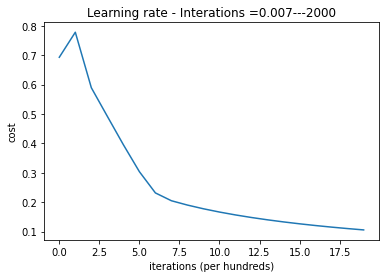

In [61]:
plt.plot(J_arr)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate - Interations =" + str(alpha) + '---' +str(iterations))
plt.show()

# 4.7 - predict

- test set
- predict test accuracy

In [62]:
def predict (W, b, X, Y):
    A = forward_propagation(W, b, X)
    m = A.shape[1]
    Y_prediction = np.zeros((1, m))
    for i in range(m):
        Y_prediction[0, i] =  1 if A[0, i] > 0.5 else 0
    return Y_prediction

Y_prediction_train = predict(W, b, X, Y)
Y_prediction_test = predict(W, b, test_set_flatten, test_y)


# train set 精确度预测
train_accuracy = (1 - np.mean(abs(Y_prediction_train - Y))) * 100
print('train accuracy: {} %', format(train_accuracy))


# test set 精确度预测
test_accuracy = (1 - np.mean(abs(Y_prediction_test - test_y))) * 100
print('test accuracy: {} %', format(test_accuracy))

train accuracy: {} % 99.52153110047847
test accuracy: {} % 68.0



# 4.8 验证某一张图片

某张 test_set 数据, 验证是否满足预测条件

test label: 1
test prediction: 1.0


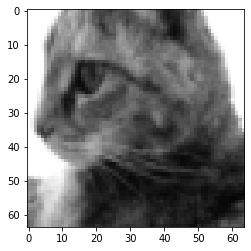

In [63]:
index = 23

# (12288, 50)
data = test_set_flatten[:, index]
image = data.reshape(64, 64, 3)
plt.imshow(image)

print('test label:', test_y[0, index])

print('test prediction:', Y_prediction_test[0, index])

# 4.9 自己找张图片验证一哈

In [53]:
image = np.array(imageio.imread("data/cat.jpg"))

plt.imshow(image)

FileNotFoundError: No such file: '/Users/linjiayu/Meituan/SELF_LEARN/Deep-Learning/coursera/[L1] Neural Networks and Deep Learning/data/cat.jpg'

In [502]:
# image.reshape(image.shape[0], -1).T 
image_flatten = image.flatten() / 255
image_flatten = np.array([image_flatten]).T

In [504]:
Y_prediction_self = predict(W, b, image_flatten, [[1]])
print('self-image prediction:', Y_prediction_self)

self-image prediction: [[1.]]
